<a href="https://colab.research.google.com/github/0xQuirKai/0xQuirkai/blob/main/aRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/tmp/ipython-input-1170265202.py:32: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(


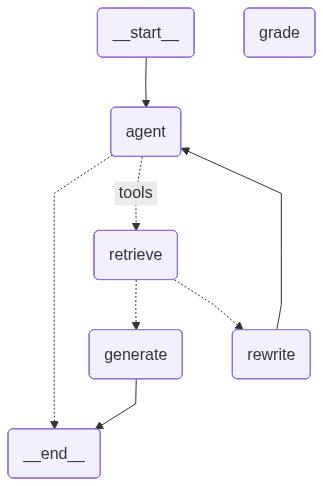


QUESTION: How does Uber distinguish between monitoring and observability?
============================================================tavily_api_key
Message: content='How does Uber distinguish between monitoring and observability?' additional_kwargs={} respo...
✓ Tool Called: web_search
---GRADE: DOCUMENT RELEVANT---
✓ Tool Response: 9300 chars
✓ AI Response: According to the provided context, Uber distinguishes between monitoring and observability as follows:

Monitoring is a subset of observability and is primarily focused on detecting known issues and a...

QUESTION: Who won the football ballon d'or 2016?
============================================================tavily_api_key
Message: content="Who won the football ballon d'or 2016?" additional_kwargs={} response_metadata={} id='52c7f...
✓ Tool Called: web_search
---GRADE: DOCUMENT RELEVANT---
✓ Tool Response: 8639 chars
✓ AI Response: Cristiano Ronaldo won the 2016 Ballon d'Or award....


In [6]:

# ===== STEP 1: Load and Split Documents =====
urls = [
    "https://www.uber.com/en-IN/blog/from-monitoring-to-observability-cloud-native/",
    "https://www.uber.com/en-IN/blog/from-static-rate-limiting-to-intelligent-load-management",
    "https://www.uber.com/en-IN/blog/apache-hudi-at-uber",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# ===== STEP 2: Create Vector Store =====
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    embedding=embeddings
)
retriever = vectorstore.as_retriever(search_kwargs={"k": 6})

# ===== STEP 3: Define Tools =====
@tool
def retrieve_blog_posts(query: str) -> str:
    """Search and return information about Uber blog posts."""
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

# Initialize Tavily Search
tavily_tool = TavilySearchResults(
    max_results=5,
    name="web_search",
    description="Search the web for current information, recent events, facts, news, statistics, sports results, company announcements, etc." ,
  tavily_api_key = userdata.get("TAVILY_API_KEY")

)

tools = [retrieve_blog_posts, tavily_tool]

# ===== STEP 4: Initialize LLM =====
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
    api_key=userdata.get('groq')
)

# ===== STEP 5: Define Node Functions =====
def generate_query_or_respond(state: MessagesState):
    """Agent node that decides which tool to use"""
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""
    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n"
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)

def grade_documents(state: MessagesState) -> Literal["generate", "rewrite"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    structured_grader = llm.with_structured_output(GradeDocuments)
    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = structured_grader.invoke([{"role": "user", "content": prompt}])

    score = response.binary_score.lower().strip()

    if score == "yes":
        print("---GRADE: DOCUMENT RELEVANT---")
        return "generate"
    else:
        print("---GRADE: DOCUMENT NOT RELEVANT---")
        return "rewrite"

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question: {question}\n"
    "Formulate an improved question:"
)

def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}

GENERATE_PROMPT = (
    "You are an accurate technical assistant answering questions about Uber Engineering blog posts and general knowledge.\n"
    "Use the provided context to answer the question. If you cannot find the answer in the context, say so.\n"
    "Question: {question}\n"
    "Context: {context}\n"
    "Answer:"
)

def generate_answer(state: MessagesState):
    """Generate an answer based on retrieved context."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

# ===== STEP 6: Build Graph =====
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("agent", generate_query_or_respond)
workflow.add_node("retrieve", ToolNode(tools))
workflow.add_node("grade", grade_documents)
workflow.add_node("rewrite", rewrite_question)
workflow.add_node("generate", generate_answer)

# Add edges
workflow.add_edge(START, "agent")

# Conditional routing from agent
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

# Routing after retrieval
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)

workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile graph
app = workflow.compile()

# ===== STEP 7: Visualize Graph =====
display(Image(app.get_graph().draw_mermaid_png()))

# ===== STEP 8: Test the Graph =====
test_questions = [
    "How does Uber distinguish between monitoring and observability?",
    "Who won the football ballon d'or 2016?"
]

for question in test_questions:
    print(f"\n{'='*60}")
    print(f"QUESTION: {question}")
    print(f"{'='*60}tavily_api_key")

    inputs = {"messages": [("user", question)]}

    for chunk in app.stream(inputs, stream_mode="values"):
        last_msg = chunk["messages"][-1]

        if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
            tool_name = last_msg.tool_calls[0]['name']
            print(f"✓ Tool Called: {tool_name}")
        elif last_msg.type == "tool":
            print(f"✓ Tool Response: {len(last_msg.content)} chars")
        elif last_msg.type == "ai":
            print(f"✓ AI Response: {last_msg.content[:200]}...")
        else:
            print(f"Message: {str(last_msg)[:100]}...")

In [5]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from google.colab import userdata
from pydantic import BaseModel, Field
from typing import Literal
from langchain.messages import HumanMessage
from IPython.display import Image, display


In [4]:
pip install -U langchain_groq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 3.9 MB/s eta 0:00:00
